In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from scipy.signal import correlate
import h5py
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
# Plot style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=20)          # text size
plt.rc('axes', titlesize=24)     # axes title size
plt.rc('axes', labelsize=24)     # axes label size
plt.rc('xtick', labelsize=20)    # x-tick label size
plt.rc('ytick', labelsize=20)    # y-tick label size
plt.rc('legend', fontsize=22)    # legend font size
plt.rc('figure', titlesize=20)   # figure title size

# Extracting Data

In [3]:
def extract_data(folder):
    '''
    This is a better data extraction function to use for this project. 
    In particular this extracts the dataArray columns from each file 
    and assigns them to variable names; which are the filename appended 
    with either '_HN_data' or '_WL_data' respectively. This is just for
    easier plotting through a loop since there two time the number of files
    of data that need to be plotted before averaging.
    '''
    data_dict = {}

    for filename in os.listdir(folder):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder, filename)
            file_key = os.path.splitext(filename)[0]

            try:
                # Try loading with scipy.io (for most MATLAB files)
                mat_data = sio.loadmat(file_path)
                clean_data = {k: v for k, v in mat_data.items() if not k.startswith('__')}

            except NotImplementedError:
                # If it's a v7.3 (HDF5-based) file, use h5py
                with h5py.File(file_path, 'r') as f:
                    clean_data = {}
                    def recursively_load(name, obj):
                        if isinstance(obj, h5py.Dataset):
                            clean_data[name] = np.array(obj)
                    f.visititems(recursively_load)

            # Extract 'dataArray' key from file structure
            if 'dataArray' in clean_data:
                arr = clean_data['dataArray']
                if arr.ndim == 2 and arr.shape[1] >= 2:
                    HN_data = arr[:, 0]
                    WL_data = arr[:, 1]

                    data_dict[f'{file_key}_HN_data'] = HN_data
                    data_dict[f'{file_key}_WL_data'] = WL_data

            # Metadata stored here incase it is needed here later for some reason
            meta = {}
            for key in ['runTime', 'xCenCorrection', 'xLinear', 'xLinearStage']:
                if key in clean_data:
                    meta[key] = clean_data[key]
            data_dict[f'{file_key}_meta'] = meta

    return data_dict

In [4]:
path = '../Team32025/WLI_With_Glass_20251015/'
data = extract_data(path)

# Shifting and Averaging Data (with glass)

In [5]:
# Look at metadata for a few files
for i, key in enumerate(sorted(data.keys())):
    if key.endswith('_meta'):
        print(f"\n{key}:")
        meta = data[key]
        for meta_key, meta_value in meta.items():
            print(f"  {meta_key}: {meta_value}")
        if i >= 0:  # first x files
            break

#data['raw_data_007_20251015_meta']['xLinear']            


processed_data_001_20251015_meta:
  runTime: ['20251015']
  xCenCorrection: [[0]]
  xLinear: [[-0.0768   -0.076725 -0.07665  ...  0.076575  0.07665   0.076725]]
  xLinearStage: [[-0.070491 ]
 [-0.0703262]
 [-0.0701614]
 ...
 [ 0.0701072]
 [ 0.070176 ]
 [ 0.0702584]]


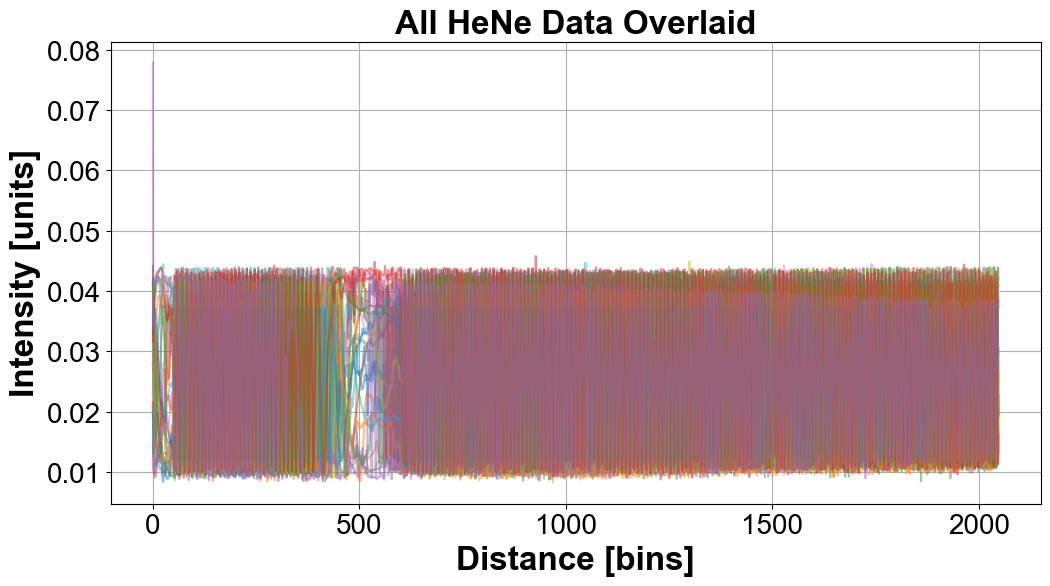

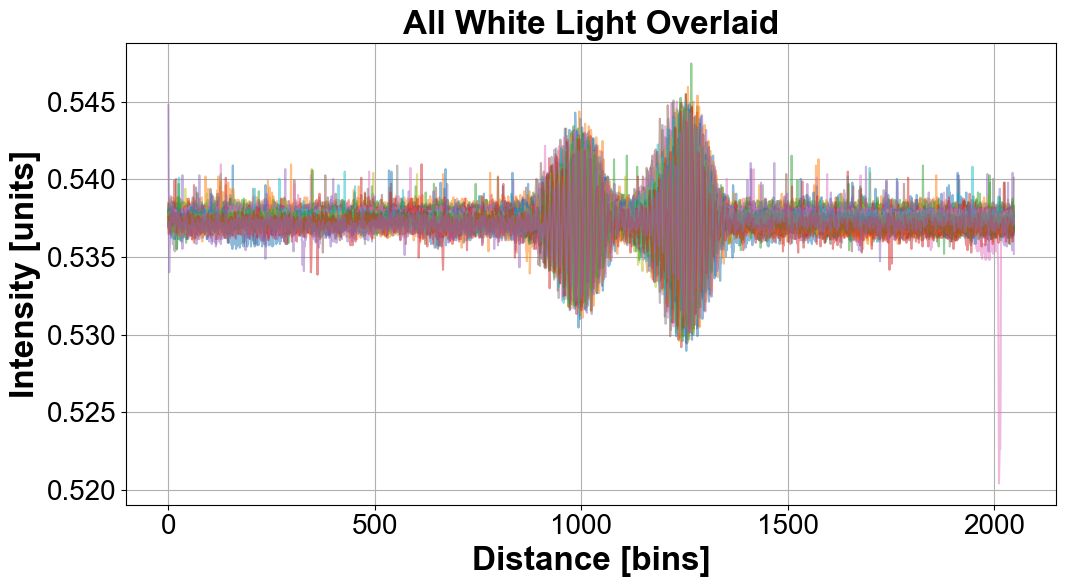

In [6]:
# Take all *_HN_data and *_WL_data arrays to see if they have different baselines

hn_arrays = []
wl_arrays = []
xlin_arrays = []
labels = []

for key in sorted(data.keys()):
    if key.endswith('_HN_data'):
        base_key = key[:-8]
        wl_key = f'{base_key}_WL_data'
        meta_key = f'{base_key}_meta'
        
        if wl_key in data:
            hn_arrays.append(data[key])
            wl_arrays.append(data[wl_key])
            xlin_arrays.append(data[meta_key]['xLinear'])
            labels.append(base_key)

# Overlay all HN data on one plot to see variations
plt.figure(figsize=(12, 6))
for i, (hn, label) in enumerate(zip(hn_arrays, labels)):
    plt.plot(hn, alpha=0.5, label=label if i < 5 else None)  # Only label first 5 to avoid clutter
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('All HeNe Data Overlaid', fontweight='bold')
if len(labels) <= 5:
    plt.legend()
plt.grid(True)
plt.show()

# WL data overlaid
plt.figure(figsize=(12, 6))
for i, (wl, label) in enumerate(zip(wl_arrays, labels)):
    plt.plot(wl, alpha=0.5, label=label if i < 5 else None)
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('All White Light Overlaid', fontweight='bold')
if len(labels) <= 5:
    plt.legend()
plt.grid(True)
plt.show()

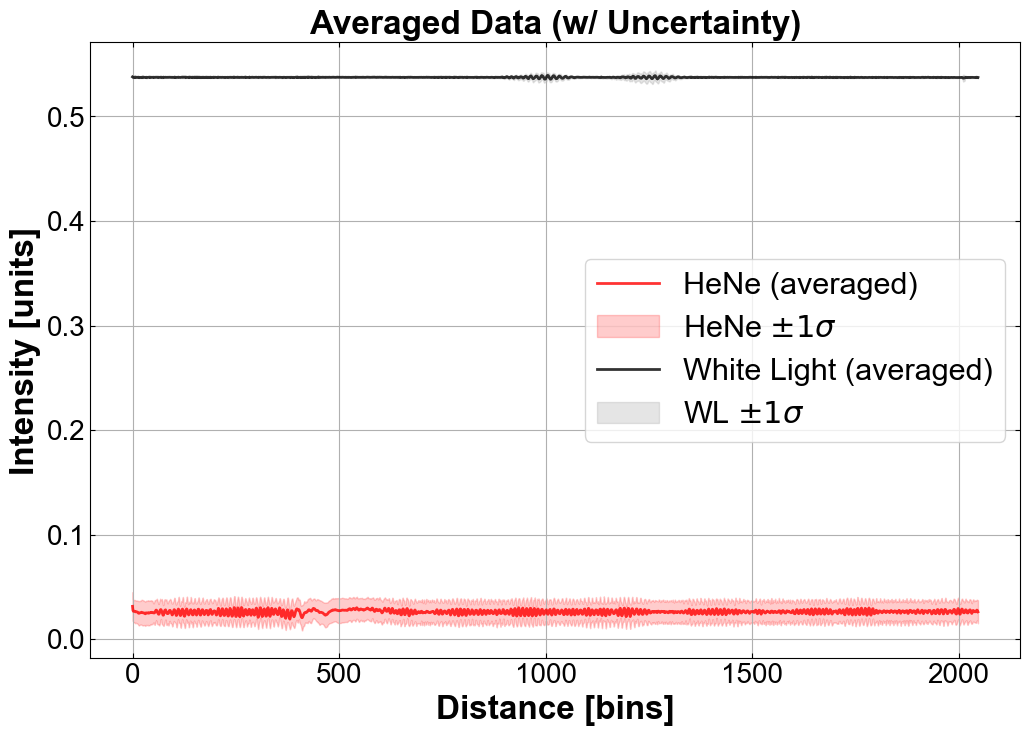

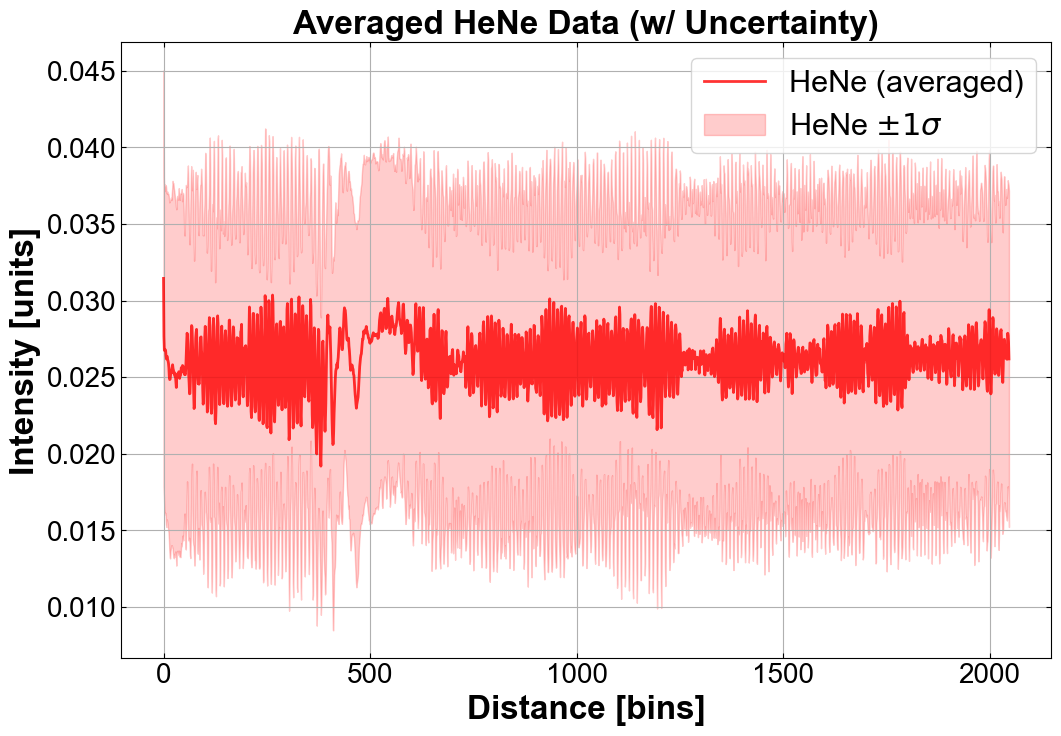

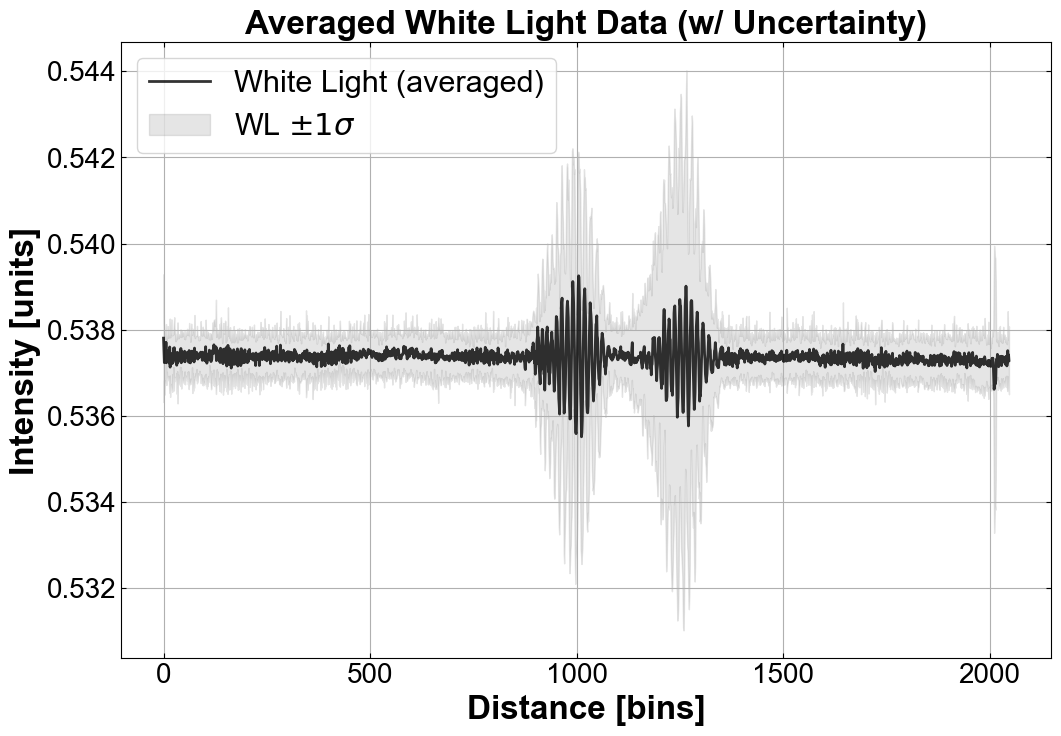

In [7]:
# Convert to numpy arrays
hn_arrays = np.array(hn_arrays)
wl_arrays = np.array(wl_arrays)

# Take average of all data
hn_avg = np.mean(hn_arrays, axis=0)
wl_avg = np.mean(wl_arrays, axis=0)

# Compute standard deviation to see uncertainty
hn_std = np.std(hn_arrays, axis=0)
wl_std = np.std(wl_arrays, axis=0)

# Plot averaged data with std error
plt.figure(figsize=(12, 8))
plt.plot(hn_avg, label='HeNe (averaged)', color='red', alpha=0.8, linewidth=2)
plt.fill_between(range(len(hn_avg)), hn_avg - hn_std, hn_avg + hn_std, 
                 color='red', alpha=0.2, label=r'HeNe $\pm 1 \sigma$')
plt.plot(wl_avg, label='White Light (averaged)', color='black', alpha=0.8, linewidth=2)
plt.fill_between(range(len(wl_avg)), wl_avg - wl_std, wl_avg + wl_std, 
                 color='gray', alpha=0.2, label=r'WL $\pm 1 \sigma$')
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('Averaged Data (w/ Uncertainty)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()

# Individual plots so data can be seen more clearly
plt.figure(figsize=(12, 8))
plt.plot(hn_avg, label='HeNe (averaged)', color='red', alpha=0.8, linewidth=2)
plt.fill_between(range(len(hn_avg)), hn_avg - hn_std, hn_avg + hn_std, 
                 color='red', alpha=0.2, label=r'HeNe $\pm 1 \sigma$')
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('Averaged HeNe Data (w/ Uncertainty)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(wl_avg, label='White Light (averaged)', color='black', alpha=0.8, linewidth=2)
plt.fill_between(range(len(wl_avg)), wl_avg - wl_std, wl_avg + wl_std, 
                 color='gray', alpha=0.2, label=r'WL $\pm 1 \sigma$')
plt.xlabel('Distance [bins]', fontweight='bold')
plt.ylabel('Intensity [units]', fontweight='bold')
plt.title('Averaged White Light Data (w/ Uncertainty)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()

## Checking to see how good averaging actually is 

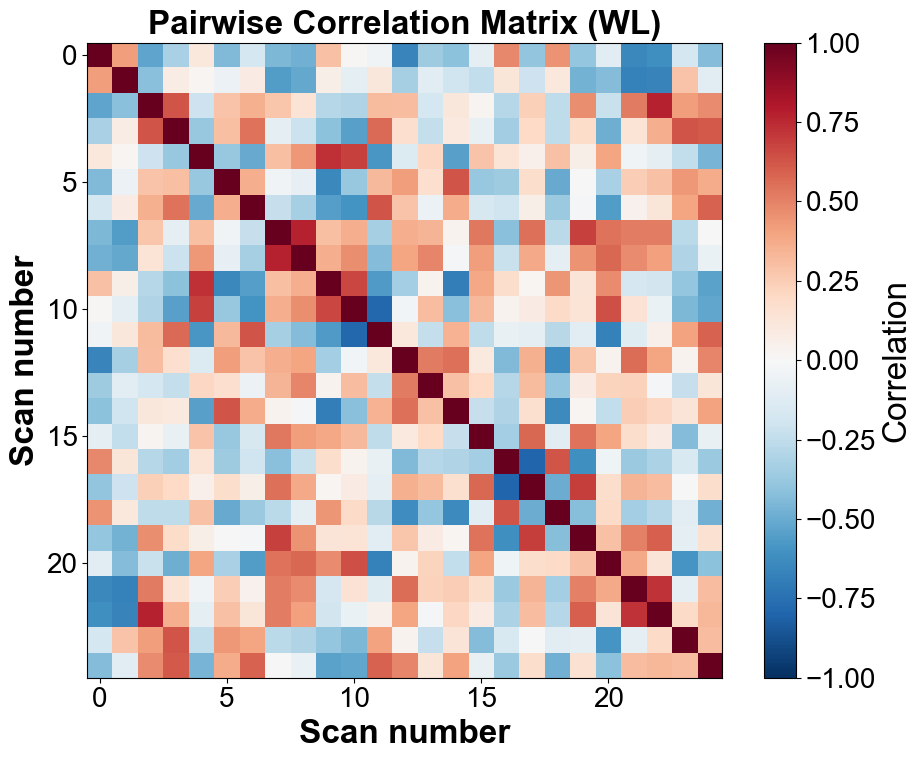

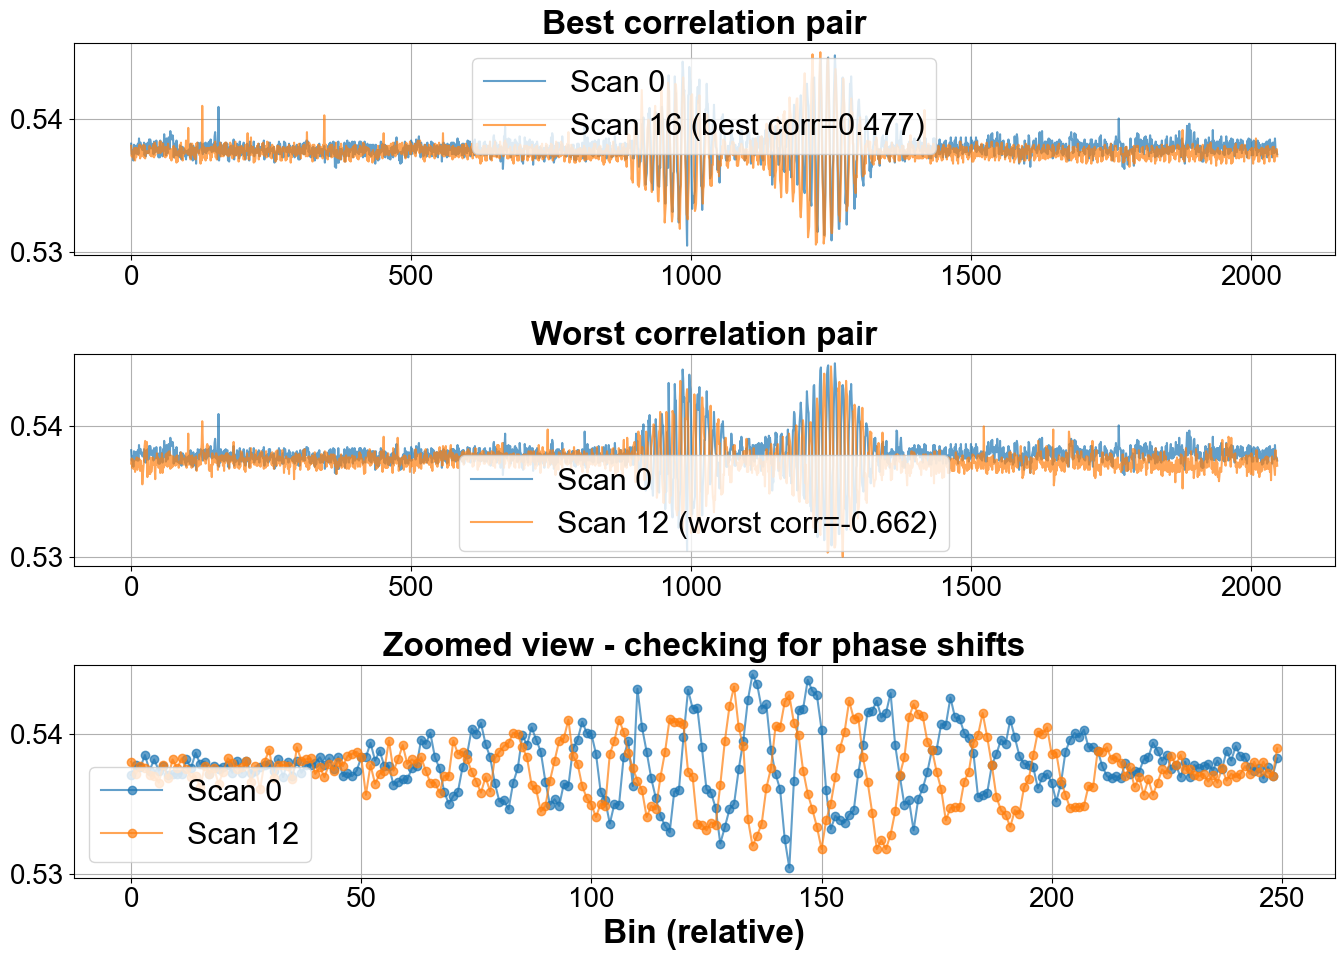

In [8]:
start_bin = 0
end_bin = 2048

hn_cropped = [hn[start_bin:end_bin] for hn in hn_arrays]
wl_cropped = [wl[start_bin:end_bin] for wl in wl_arrays]

n_scans = len(wl_cropped)
corr_matrix = np.zeros((n_scans, n_scans))

for i in range(n_scans):
    for j in range(n_scans):
        #print(f'i: {i}, j: {j}')
        corr, _ = pearsonr(wl_cropped[i], wl_cropped[j])
        corr_matrix[i, j] = corr

# Plot correlation matrix
plt.figure(figsize=(10, 8))
im = plt.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation')
plt.xlabel('Scan number', fontweight='bold')
plt.ylabel('Scan number', fontweight='bold')
plt.title('Pairwise Correlation Matrix (WL)', fontweight='bold')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

best_match_idx = np.argmax(corr_matrix[0, 1:]) + 1
axes[0].plot(wl_cropped[0], label='Scan 0', alpha=0.7)
axes[0].plot(wl_cropped[best_match_idx], label=f'Scan {best_match_idx} (best corr={corr_matrix[0, best_match_idx]:.3f})', alpha=0.7)
axes[0].set_title('Best correlation pair', fontweight='bold')
axes[0].legend()
axes[0].grid(True)

worst_match_idx = np.argmin(corr_matrix[0, 1:]) + 1
axes[1].plot(wl_cropped[0], label='Scan 0', alpha=0.7)
axes[1].plot(wl_cropped[worst_match_idx], label=f'Scan {worst_match_idx} (worst corr={corr_matrix[0, worst_match_idx]:.3f})', alpha=0.7)
axes[1].set_title('Worst correlation pair', fontweight='bold')
axes[1].legend()
axes[1].grid(True)

zoom_start = 850
zoom_end = 1100
axes[2].plot(wl_cropped[0][zoom_start:zoom_end], 'o-', label='Scan 0', alpha=0.7)
axes[2].plot(wl_cropped[worst_match_idx][zoom_start:zoom_end], 'o-', label=f'Scan {worst_match_idx}', alpha=0.7)
axes[2].set_title('Zoomed view - checking for phase shifts', fontweight='bold')
axes[2].set_xlabel('Bin (relative)', fontweight='bold')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [9]:
xlin_arrays = np.array(xlin_arrays)
xlin_avg = np.mean(xlin_arrays, axis=0)[0]
xlin_std = np.std(xlin_arrays, axis=0)[0]

# dumb stuff you don't really need to care about. 
# all this does is show that each of the xLinear data sets are basically exactly the same thing
import struct
def float2bin(f):
    (d,) = struct.unpack(">Q", struct.pack(">d", f))
    return f'{d:064b}'

def bin2float(b):
    b = b.replace(' ', '')
    b = int(b,2)
    (f,) = struct.unpack(">d", struct.pack(">Q", b))
    return f

#float2bin(1)
n0 = '0011111111110000000000000000000000000000000000000000000000000000'
n1 = '0011111111110000000000000000000000000000000000000000000000000001'
eps = bin2float(n1) - bin2float(n0)
#eps    
xlin_std[xlin_std < eps] = 0

In [10]:
max_shift = 12  # maximum shift
threshold = 0.1  # min correlation

n = len(hn_cropped)

shifts = []

reference = wl_cropped[0]

for i in range(1, n):  # skips reference scan 
    best_corr = -1
    best_shift = 0
    
    # try shifts from -max_shift to +max_shift
    for shift in range(-max_shift, max_shift + 1):
        shifted = np.roll(wl_cropped[i], shift)
        corr, _ = pearsonr(reference, shifted)
        if corr > best_corr:
            best_corr = corr
            best_shift = shift
    shifts.append(best_shift)

    # Apply the best shift if correlation is below threshold
    if best_corr < threshold:
        print(f"Scan {i}: best corr = {best_corr:.3f}, but below threshold ({threshold}). Applying shift {best_shift}.")
    else:
        print(f"Scan {i}: best corr = {best_corr:.3f}, applying shift {best_shift}.")
    
    # Shift the data
    hn_cropped[i] = np.roll(hn_cropped[i], best_shift)
    wl_cropped[i] = np.roll(wl_cropped[i], best_shift)

Scan 1: best corr = 0.550, applying shift -12.
Scan 2: best corr = 0.552, applying shift 6.
Scan 3: best corr = 0.631, applying shift -9.
Scan 4: best corr = 0.573, applying shift -3.
Scan 5: best corr = 0.634, applying shift 5.
Scan 6: best corr = 0.672, applying shift -9.
Scan 7: best corr = 0.775, applying shift 8.
Scan 8: best corr = 0.743, applying shift 8.
Scan 9: best corr = 0.663, applying shift -2.
Scan 10: best corr = 0.636, applying shift -3.
Scan 11: best corr = 0.694, applying shift -10.
Scan 12: best corr = 0.644, applying shift -7.
Scan 13: best corr = 0.458, applying shift -5.
Scan 14: best corr = 0.513, applying shift 5.
Scan 15: best corr = 0.550, applying shift 10.
Scan 16: best corr = 0.477, applying shift 0.
Scan 17: best corr = 0.510, applying shift 8.
Scan 18: best corr = 0.532, applying shift -1.
Scan 19: best corr = 0.573, applying shift 8.
Scan 20: best corr = 0.693, applying shift -4.
Scan 21: best corr = 0.694, applying shift -6.
Scan 22: best corr = 0.602, 

In [11]:
avg_shift = int(np.mean(shifts))
avg_shift # lol

0

## Actual Plots of Averages

Probably don't use HeNe Data

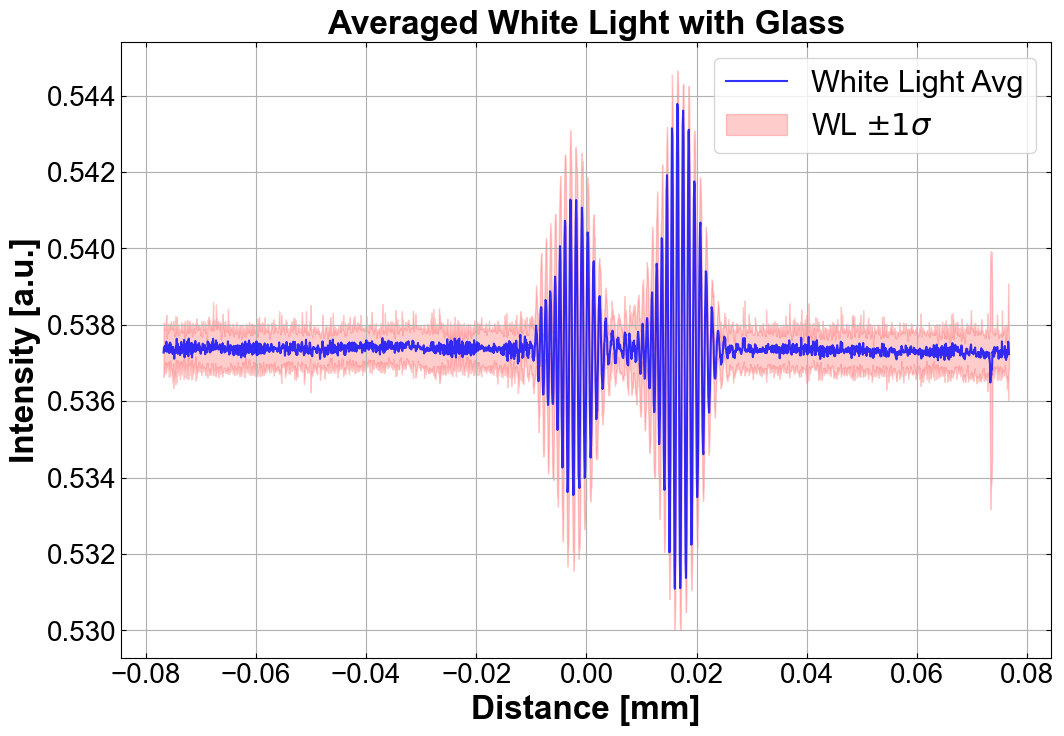

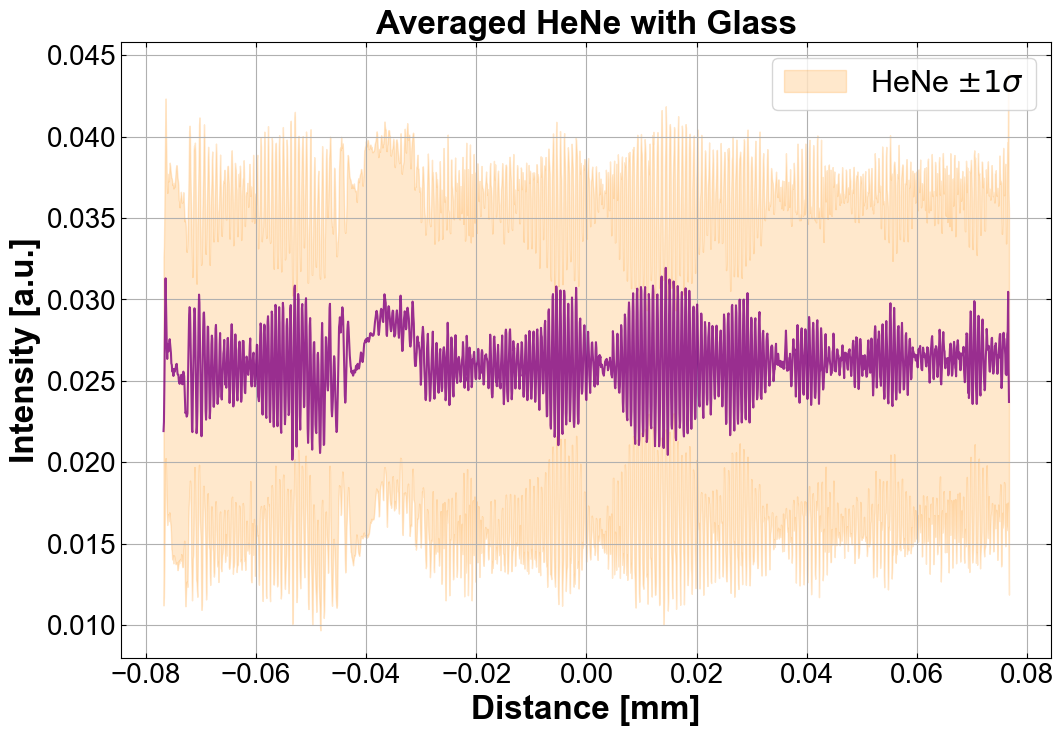

In [12]:
wl_shift_avg = np.mean(np.array(wl_cropped), axis=0)
wl_shift_std = np.std(np.array(wl_cropped), axis=0)
hn_shift_avg = np.mean(np.array(hn_cropped), axis=0)
hn_shift_std = np.std(np.array(hn_cropped), axis=0)

plt.figure(figsize=(12,8))
plt.plot(xlin_avg, wl_shift_avg, color='blue', alpha=0.8, label='White Light Avg')
plt.fill_between(xlin_avg, wl_shift_avg - wl_shift_std, wl_shift_avg + wl_shift_std, 
                 color='red', alpha=0.2, label=r'WL $\pm 1 \sigma$')
plt.xlabel('Distance [mm]',fontweight='bold')
plt.ylabel('Intensity [a.u.]',fontweight='bold')
plt.title('Averaged White Light with Glass', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()
print('\n'*4)
plt.figure(figsize=(12,8))
plt.plot(xlin_avg, hn_shift_avg, color='purple', alpha=0.8)
plt.fill_between(xlin_avg, hn_shift_avg - hn_shift_std, hn_shift_avg + hn_shift_std, 
                 color='darkorange', alpha=0.2, label=r'HeNe $\pm 1 \sigma$')
plt.xlabel('Distance [mm]',fontweight='bold')
plt.ylabel('Intensity [a.u.]', fontweight='bold')
plt.title('Averaged HeNe with Glass', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()

# Spectra and Phase (with glass)

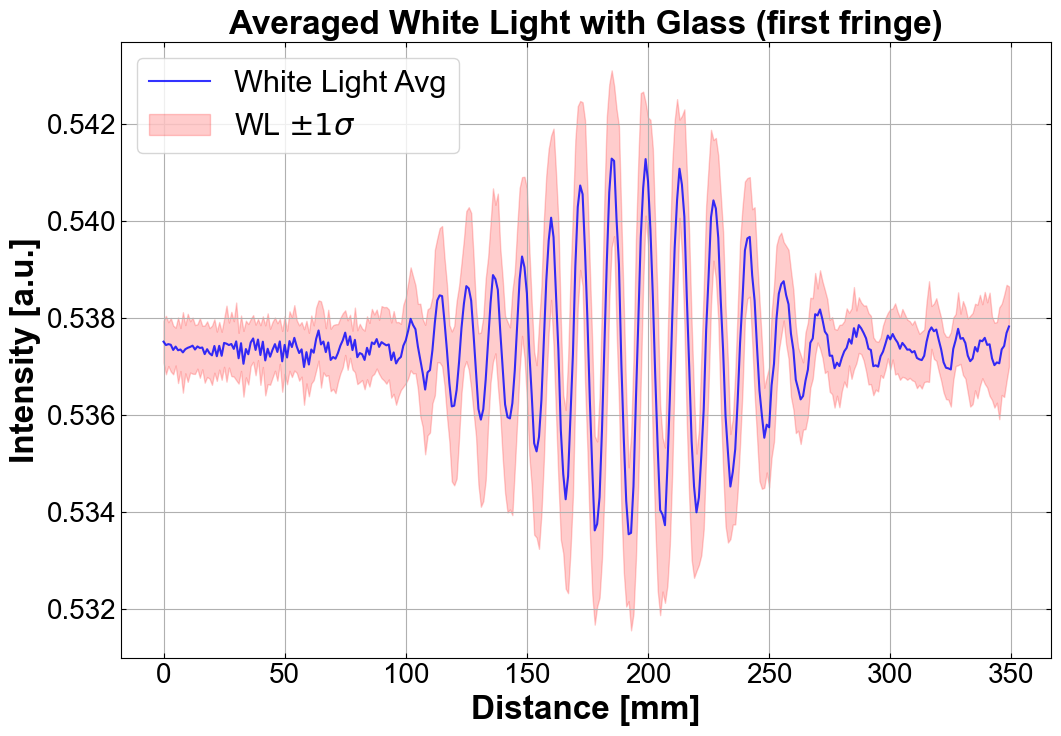

In [13]:
start1=800
end1=1150
wl_fringe1 = wl_shift_avg[start1:end1]
wl_fringe1_std = wl_shift_std[start1:end1]
plt.figure(figsize=(12,8))
plt.plot(wl_fringe1, color='blue', alpha=0.8, label='White Light Avg')
plt.fill_between(range(len(wl_fringe1)), wl_fringe1 - wl_fringe1_std,
                 wl_fringe1 + wl_fringe1_std, 
                 color='red', alpha=0.2, label=r'WL $\pm 1 \sigma$')
plt.xlabel('Distance [mm]',fontweight='bold')
plt.ylabel('Intensity [a.u.]',fontweight='bold')
plt.title('Averaged White Light with Glass (first fringe)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()

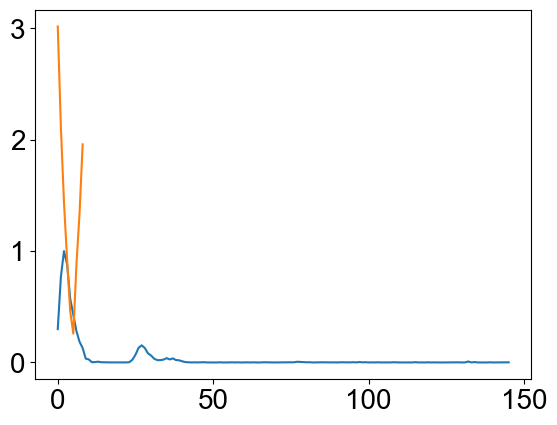

In [77]:
N=len(wl_fringe1)
c_mm_ps = 0.3 # speed of light in mm/ps
t = 2*xlin_avg[start1:end1]/c_mm_ps
dw = 2*np.pi/np.max(np.abs(t))
wMax=dw*N
w = np.arange(-wMax/2, wMax/2, dw)
lambda_um = (2*np.pi*c_mm_ps/w)*1e3

idx = (lambda_um >0.2) & (lambda_um<1.5)
lambda_selected = lambda_um[idx]
baseline_idx = 50

field = wl_fringe1 - wl_fringe1[baseline_idx]
field[field<-0.0003] =0
#plt.plot(field)
#print(np.mean(field))
field_fft = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(field)))
#plt.plot(field_fft)
spectrum = np.abs(field_fft)**2
spectrum = spectrum[idx]
spectrum = (spectrum-spectrum.min())/(spectrum.max()-spectrum.min())
plt.plot(spectrum)
phase = np.unwrap(np.angle(field_fft[idx]))
phaseBlank = spectrum<0.1
phase[phaseBlank] = np.nan
plt.plot(phase[0:20])

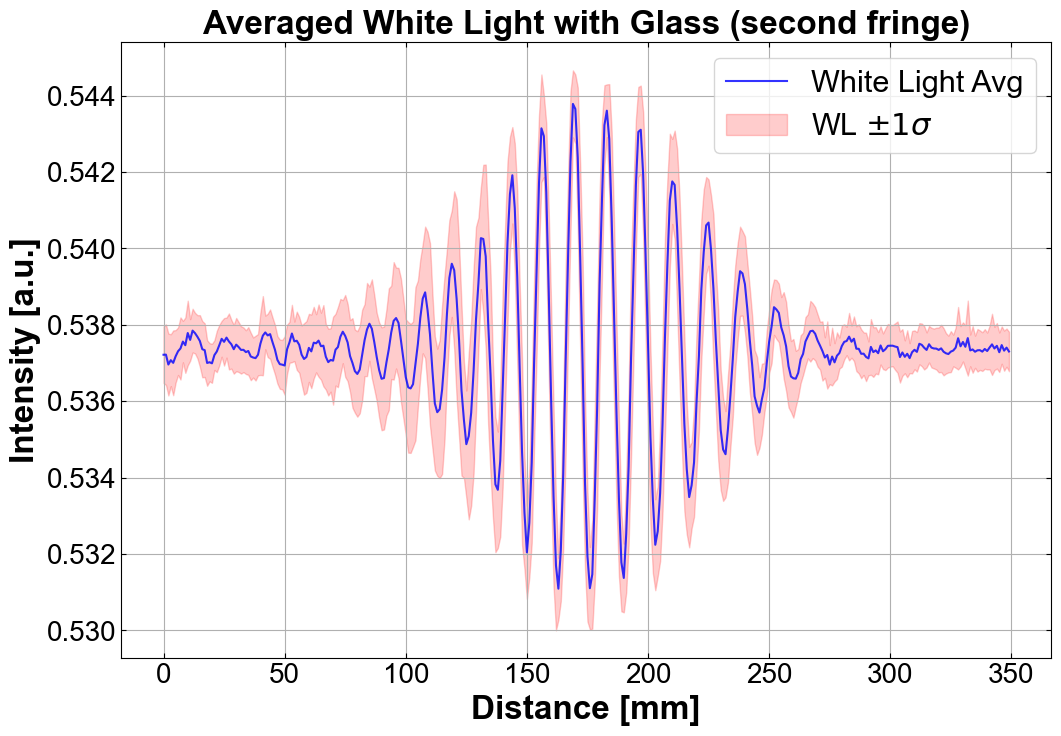

In [15]:
start2=1075
end2=1425
wl_fringe2 = wl_shift_avg[start2:end2]
wl_fringe2_std = wl_shift_std[start2:end2]
plt.figure(figsize=(12,8))
plt.plot(wl_fringe2, color='blue', alpha=0.8, label='White Light Avg')
plt.fill_between(range(len(wl_fringe2)), wl_fringe2 - wl_fringe2_std,
                 wl_fringe2 + wl_fringe2_std, 
                 color='red', alpha=0.2, label=r'WL $\pm 1 \sigma$')
plt.xlabel('Distance [mm]',fontweight='bold')
plt.ylabel('Intensity [a.u.]',fontweight='bold')
plt.title('Averaged White Light with Glass (second fringe)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.show()

In [16]:
for key in data.keys():
    if key.startswith('processed_data_'):
        print(key)

processed_data_007_20251015_meta
processed_data_019_20251015_meta
processed_data_010_20251015_meta
processed_data_024_20251015_meta
processed_data_018_20251015_meta
processed_data_008_20251015_meta
processed_data_006_20251015_meta
processed_data_020_20251015_meta
processed_data_001_20251015_meta
processed_data_013_20251015_meta
processed_data_021_20251015_meta
processed_data_005_20251015_meta
processed_data_014_20251015_meta
processed_data_016_20251015_meta
processed_data_023_20251015_meta
processed_data_009_20251015_meta
processed_data_025_20251015_meta
processed_data_022_20251015_meta
processed_data_002_20251015_meta
processed_data_017_20251015_meta
processed_data_011_20251015_meta
processed_data_003_20251015_meta
processed_data_004_20251015_meta
processed_data_015_20251015_meta
processed_data_012_20251015_meta


In [35]:
data['processed_data_007_20251015_meta']

{'runTime': array(['20251015'], dtype='<U8'),
 'xCenCorrection': array([[0]], dtype=uint8),
 'xLinear': array([[-0.0768  , -0.076725, -0.07665 , ...,  0.076575,  0.07665 ,
          0.076725]]),
 'xLinearStage': array([[-0.0705048],
        [-0.0702988],
        [-0.070189 ],
        ...,
        [ 0.0700936],
        [ 0.070176 ],
        [ 0.0702446]])}